*last update 20201231*

*by MAK*

# Mounting Gdrive

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive/')
import os
%cd /content/drive/My\ Drive/ColabTemp/
%ls
!echo current directory is $(pwd)

Mounted at /content/drive/
/content/drive/My Drive/ColabTemp
2021.CoCryM.ExSysR/  FP_COEFF.csv               Plot_fingerprints.ipynb
BuiltaModule.ipynb   FP_inv_tMATRIX_MATRIX.csv  RamanSpectra.xlsx
ExSys_00.ipynb       FP_MATRIX.csv              rxtDPD.ipynb
ExSysR_01.ipynb      FP_tMATRIX.csv
ExSysR_02.ipynb      FP_tMATRIX_MATRIX.csv
current directory is /content/drive/My Drive/ColabTemp


# Importing all packages ...

In [ ]:
import time
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
from random import random

# Reading deposited Raman data 



and averaging over temperatures while smoothing and trimming to Spectra within (400, 3700) cm-1, followed by normalization

In [ ]:
tic = time.clock()
file = 'RamanSpectra.xlsx'
xl = pd.ExcelFile(file)
List = xl.sheet_names
xs = np.linspace(400, 3700, 1000)
FP_norm = np.transpose(xs)
FP_avg = np.transpose(xs)
for item in List: 
  data = xl.parse(item)
  np_data = data.to_numpy()
  tr_data = np_data[ np.where( np_data[:, 0] > 400 ) ]
  x298 = tr_data[:, 0]
  y298 = tr_data[:, 1]
  spl = UnivariateSpline(x298, y298)
  spl.set_smoothing_factor(0.00000001)
  ys298 = spl(xs)
  x343 = tr_data[:, 2]
  y343 = tr_data[:, 3]
  spl = UnivariateSpline(x343, y343)
  spl.set_smoothing_factor(0.00000001)
  ys343 = spl(xs)
  x353 = tr_data[:, 4]
  y353 = tr_data[:, 5]
  spl = UnivariateSpline(x353, y353)
  spl.set_smoothing_factor(0.00000001)
  ys353= spl(xs)
  x363 = tr_data[:, 6]
  y363 = tr_data[:, 7]
  spl = UnivariateSpline(x363, y363)
  spl.set_smoothing_factor(0.00000001)
  ys363 = spl(xs)
  x_avg = xs
  y_avg = (ys298 + ys343 + ys353 + ys363) / 4
  y_avg = abs(y_avg)
  FP_avg = np.vstack((FP_avg, np.transpose(y_avg)))
  MIN = y_avg.min()
  if MIN == 0:
    MIN = 1e-8
  MAX = y_avg.max()
  norm_y = (y_avg - MIN) / (MAX - MIN)
  FP_norm = np.vstack((FP_norm, np.transpose(norm_y)))
toc = time.clock()
print('elapsed time = ', toc - tic, ' s')

elapsed time =  10.35922  s


# Preparing datasets 

In [ ]:
tic = time.clock()
FP_spectra = np.transpose(np.linspace(400, 3700, 1000))
FP_intensity = np.transpose(FP_norm[1:,:])
Particle_Name = np.array(List)
#Particle_ID = np.array([1000, 2000, \
#                        1, 2, 3, 4, 5, 6, 12, 13, 18, \
#                        7, 8, 17, \
#                        9, 10, 11, 14, 15, 16, 19, 20, 21])
toc = time.clock()
print('elapsed time = ', toc - tic, ' s')

elapsed time =  0.00041500000000027626  s


# Building MATRIX for **dVFS** model

In [ ]:
tic = time.clock()
# first column of big MATRIX - fixed value = 1
MATRIX = np.ones((FP_spectra.shape[0],1))
# pair data 
MATRIX = np.hstack((MATRIX, FP_intensity))
# binaries of (i,j) 
i = 0
for particles in List:
  j = 0
  for particles in List:
    TEMP = np.zeros((FP_spectra.shape[0],1))
    TEMP[:,0] = FP_intensity[:,i] * FP_intensity[:,j]
    MATRIX = np.hstack((MATRIX, TEMP))
    j = j + 1
  i = i + 1
# triplets of (i, j, k)
i = 0
for particles in List:
  j = 0
  for particles in List:
    k = 0
    for particles in List:
      TEMP = np.zeros((FP_spectra.shape[0],1))
      TEMP[:,0] = FP_intensity[:,i] * FP_intensity[:,j] * FP_intensity[:,k]
      MATRIX = np.hstack((MATRIX, TEMP))
      k = k + 1
    j = j + 1
  i = i + 1
toc = time.clock()
print('elapsed time = ', toc - tic, ' s')

elapsed time =  200.82933200000002  s


In [ ]:
tic = time.clock()
tMATRIX = np.transpose(MATRIX)
tMATRIX_MATRIX = np.matmul(tMATRIX, MATRIX)
inv_tMATRIX_MATRIX = np.linalg.pinv(tMATRIX_MATRIX)
toc = time.clock()
print('elapsed time = ', toc - tic, ' s')

elapsed time =  3271.396557  s


# Evaluating dVFS for fingerprints

In [ ]:
tic = time.clock()
FP_COEFF = np.zeros((MATRIX.shape[1],len(List)-2))
FP_ERR = np.zeros((len(List)-2,1))
i = 0
j = 0
for particle in List:
  if i > 2: 
    Y = FP_intensity[:,i]
    tMATRIX_Y = np.matmul(tMATRIX, Y) 
    FP_COEFF[:, j] = np.matmul(inv_tMATRIX_MATRIX, tMATRIX_Y)
    Y_cal = np.matmul(MATRIX, FP_COEFF[:, j])
    Err = abs(Y - Y_cal)
    FP_ERR[j,0] = Err.sum()
    j = j + 1
  i = i + 1
toc = time.clock()
print('elapsed time = ', toc - tic, ' s')

elapsed time =  5.406902000000173  s


# Saving ...

In [ ]:
tic = time.clock()
np.savetxt("FP_COEFF.csv", FP_COEFF, delimiter=",")
np.savetxt("FP_MATRIX.csv", MATRIX, delimiter=",")
np.savetxt("FP_tMATRIX.csv", tMATRIX, delimiter=",")
np.savetxt("FP_tMATRIX_MATRIX.csv", tMATRIX_MATRIX, delimiter=",")
np.savetxt("FP_inv_tMATRIX_MATRIX.csv", inv_tMATRIX_MATRIX, delimiter=",")
toc = time.clock()
print('elapsed time = ', toc - tic, ' s')

elapsed time =  387.2229849999999  s


# Creating dummy mixtures 

In [ ]:
nMIX = 10000
tic = time.clock()
MIX_intensity = np.zeros((FP_intensity.shape[0], nMIX)) 
MIX_frQ = np.zeros((nMIX, FP_intensity.shape[1])) 
for mixture in range(nMIX):
  i = 0
  rnd = np.zeros((1,len(List)))
  for particle in List:
      rnd[0,i] = random() * random() * random()
      i = i + 1
  RND = rnd / np.sum(rnd)
  MIX_frQ[mixture, :] = RND
  i = 0
  TEMP = 0
  for particle in List:
    TEMP = TEMP + FP_intensity[:, i] * RND[0, i]
    i = i + 1
  MIX_intensity[:, mixture] = TEMP
toc = time.clock()
print('elapsed time = ', toc - tic, ' s')

elapsed time =  1.2689869999999246  s


# Evaluating dVFS for mixture 

In [ ]:
tic = time.clock()
MIX_ERR = np.zeros((nMIX,1))
MIX_COEFF = np.zeros((MATRIX.shape[1],nMIX))
i = 0
j = 0
for mixture in range(nMIX):
    Y = MIX_intensity[:, mixture]
    tMATRIX_Y = np.matmul(tMATRIX, Y) 
    MIX_COEFF[:, mixture] = np.matmul(inv_tMATRIX_MATRIX, tMATRIX_Y)
    Y_cal = np.matmul(MATRIX, MIX_COEFF[:, mixture])
    Err = abs(Y - Y_cal)
    MIX_ERR[mixture,0] = Err.sum()
toc = time.clock()
print('elapsed time = ', toc - tic, ' s')

elapsed time =  2738.963695  s


# Prediciting probability in a new random Raman stream 

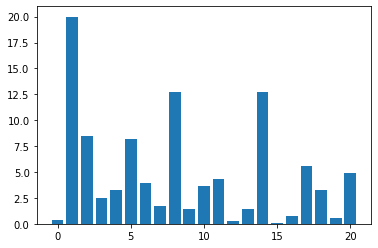

<Figure size 432x288 with 0 Axes>

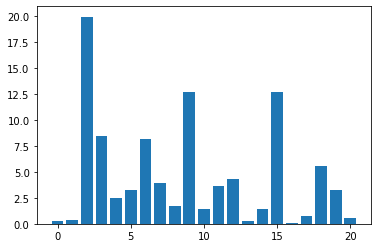

elapsed time =  0.8228250000001935  s


In [ ]:
# creating a new mixture sample 
nMIX = 1
tic = time.clock()
new_MIX_intensity = np.zeros((FP_intensity.shape[0], nMIX)) 
new_MIX_frQ = np.zeros((nMIX, FP_intensity.shape[1])) 
dVFS_MIX_frQ = np.zeros((nMIX, FP_intensity.shape[1] - 2)) 
new_MIX_COEFF = np.zeros((MATRIX.shape[1],nMIX))
for mixture in range(nMIX):
  i = 0
  rnd = np.zeros((1,len(List)))
  for particle in List:
      rnd[0,i] = random() * random() * random()
      i = i + 1
  RND = rnd / np.sum(rnd)
  new_MIX_frQ[mixture, :] = RND
  i = 0
  TEMP = 0
  for particle in List:
    TEMP = TEMP + FP_intensity[:, i] * RND[0, i]
    i = i + 1
  new_MIX_intensity[:, mixture] = TEMP
  new_Y = new_MIX_intensity[:, mixture]
  new_tMATRIX_Y = np.matmul(tMATRIX, new_Y) 
  new_MIX_COEFF[:, mixture] = np.matmul(inv_tMATRIX_MATRIX, new_tMATRIX_Y)
  dVFS_MIX_frQ[mixture, :] = 100 * new_MIX_COEFF[3:24, mixture] / np.sum(new_MIX_COEFF[3:24, mixture])
  plt.bar(range(len(dVFS_MIX_frQ[mixture, :])), dVFS_MIX_frQ[mixture, :])
  plt.figure()
  plt.show()
  plt.figure()
  plt.bar(range(len(new_MIX_frQ[mixture, 1:-1])), 100 * new_MIX_frQ[mixture, 1:-1])
  plt.show()
  toc = time.clock()
print('elapsed time = ', toc - tic, ' s')

In [ ]:
print(len(List))

23


# Prediciting probability in a new experimentally Raman stream 